In [2]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


         Passengers
Month              
1949-01       112.0
1949-02       118.0
1949-03       132.0
1949-04       129.0
1949-05       121.0


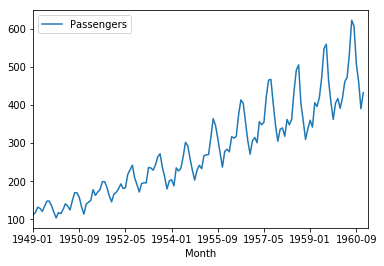

In [3]:
df = pd.read_csv('datasets/international-airline-passengers.csv', index_col='Month')
print(df.head())
df.plot()

# Data cleansing

In [4]:
columns_to_keep = ['Passengers']
df = df[columns_to_keep]
df['Passengers'] = df['Passengers'].apply(lambda x: x*1000)
df.index.names = ['Month']
df.sort_index(inplace=True)
print('Total rows: {}'.format(len(df)))
df.head()

Total rows: 146


,Passengers
Month,
1949-01,112000.0
1949-02,118000.0
1949-03,132000.0
1949-04,129000.0
1949-05,121000.0


In [5]:
df.describe()

,Passengers
count,144.000000
mean,280298.611111
std,119966.316943
min,104000.000000
25%,180000.000000
50%,265500.000000
75%,360500.000000
max,622000.000000


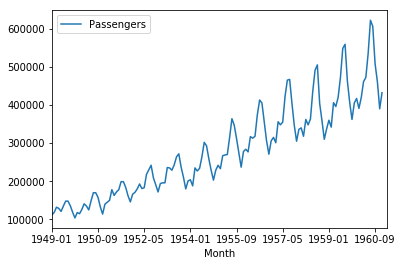

In [6]:
df.plot()

Null values?

In [7]:
df.isnull().sum()

Passengers    2
dtype: int64

In [8]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Passengers    2
dtype: int64

In [9]:
print(df[df.isnull().any(axis=1)][null_columns].head())

                                                    Passengers
Month                                                         
International airline passengers: monthly total...         NaN
NaN                                                        NaN


In [10]:
df.dropna(inplace=True)

In [11]:
df.isnull().sum()

Passengers    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ca8a6aa58>]],
      dtype=object)

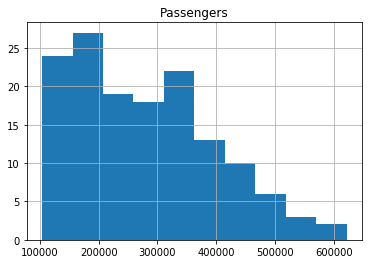

In [12]:
df.hist(bins=10)

In [13]:
len(df[df['Passengers'] == 0])

0

# Scaled data

In [39]:
print('Min', np.min(df))
print('Max', np.max(df))

Min Passengers    104000.0
dtype: float64
Max Passengers    622000.0
dtype: float64


In [40]:
dataset = df.astype('float32')

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset) 

/home/gf/packages/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [42]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


In [44]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 100
test: 44


In [53]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [58]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
print(X_train.shape)
print(X_test.shape)

100 1
44 1
(99, 1)
(43, 1)


In [59]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(99, 1, 1)
(43, 1, 1)


In [65]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [66]:
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=0, shuffle=True)

In [80]:
trainPredict = model.predict(X_train, batch_size=1)
testPredict = model.predict(X_test, batch_size=1)

trainScore = np.sqrt(np.mean((y_train-trainPredict)**2))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(np.mean((y_test-testPredict)**2))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.20 RMSE
Test Score: 0.22 RMSE


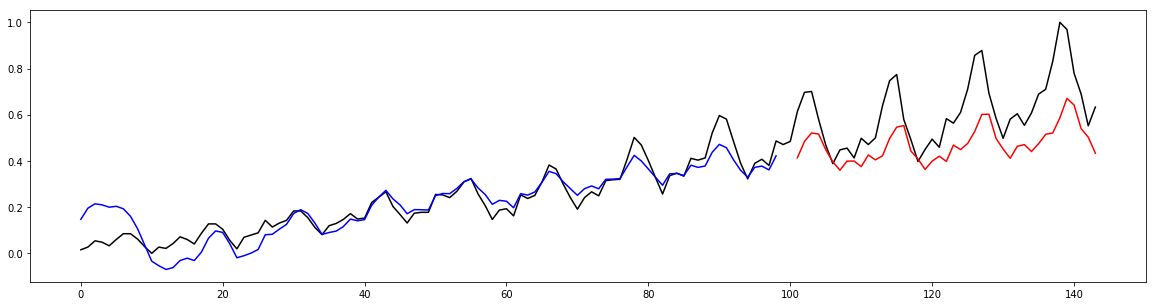

In [85]:
plt.figure(figsize=(20,5))

x = np.arange(scaled.shape[0])
plt.plot(scaled,'k')
plt.plot(trainPredict,'b')
plt.plot(x[-testPredict.shape[0]:],testPredict,'r')